# **Project: Relation Classification**


## ----- **Text Mining and Sentiment Analysis Course** ----



## **Steps**:
   ### Step 1: Data Loading and Data Exploration
   ### Step 2: Data Preprocessing
   ### Step 3: Models' Architecture
   ### Step 4: Important Functions
   ### Step 5: Training Models
   ### Step 6: Knowledge Graph


**Dataset:** relation-extraction-corpus ([link](https://code.google.com/archive/p/relation-extraction-corpus/downloads))




### **Shojaat Joodi Bigdilo**

July 2024


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
pip install transformers

In [ ]:
pip install torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, Subset

import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import BertModel
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers import BertTokenizer

from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## **Step1: Data Loading and Exploration**

In [ ]:
import json

# Example file paths
date_of_birth_file = "/content/gdrive/My Drive/Text_Mining/dob_augment-200526.json"
education_file = "/content/gdrive/My Drive/Text_Mining/education_augment-200526.json"
place_of_death_file = "/content/gdrive/My Drive/Text_Mining/pod_augment-200526.json"
place_of_birth_file = "/content/gdrive/My Drive/Text_Mining/pob_augment-200526.json"
institution_file =  "/content/gdrive/My Drive/Text_Mining/institution_augment-200526.json"


# Load the datasets
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)


# Load data
date_of_birth_data = load_dataset(date_of_birth_file)
education_data = load_dataset(education_file)
place_of_death_data = load_dataset(place_of_death_file)
place_of_birth_data = load_dataset(place_of_birth_file)
institution_data = load_dataset(institution_file)

In [ ]:
# Combine datasets into one list
data = date_of_birth_data + education_data + place_of_death_data + place_of_birth_data + institution_data

In [ ]:
data[0]

{'pred': '/people/person/date_of_birth',
 'sub': 'James Cunningham',
 'obj': '1973',
 'evidences': [{'url': 'http://en.wikipedia.org/wiki/James_Cunningham_(comedian)',
   'snippet': 'James Cunningham (born 1973 or 1974) is a Canadian stand-up comedian and TV host.'}],
 'judgments': [{'rater': '18349444711114572460', 'judgment': 'skip'},
  {'rater': '3615053018572949242', 'judgment': 'skip'},
  {'rater': '7520160179218527648', 'judgment': 'skip'},
  {'rater': '3571030073219370006', 'judgment': 'skip'},
  {'rater': '7917053321523182674', 'judgment': 'skip'}],
 'UID': 'dob_IC2Lf4X5u8',
 'maj_vote': 'skip',
 'sub_id': '/m/0gmct90',
 'obj_id': '1973',
 'dbpedia_sub': 'http://dbpedia.org/resource/James_Cunningham,_14th_Earl_of_Glencairn',
 'dbpedia_obj': 'N/A',
 'wikidata_qid_sub': 'Q6132028',
 'wikidata_qid_obj': 'Not Found'}

In [ ]:
# Define the mapping dictionary
pred_mapping = {
    '/people/person/education./education/education/institution': 'institution',
    '/people/person/date_of_birth': 'date_of_birth',
    '/people/person/education./education/education/degree': 'degree',
    '/people/deceased_person/place_of_death': 'place_of_death',
    '/people/person/place_of_birth': 'place_of_birth'
}

# Extract the relevant information
extracted_data = []
for entry in data:
    if entry['pred'] in pred_mapping:
        extracted_data.append({
            'pred': pred_mapping[entry['pred']],
            'sub': entry['sub'],
            'obj': entry['obj'],
            'evidences': entry['evidences']
        })

# assign again
data = extracted_data

In [ ]:
data[0]

{'pred': 'date_of_birth',
 'sub': 'James Cunningham',
 'obj': '1973',
 'evidences': [{'url': 'http://en.wikipedia.org/wiki/James_Cunningham_(comedian)',
   'snippet': 'James Cunningham (born 1973 or 1974) is a Canadian stand-up comedian and TV host.'}]}

## **Data Exploration**

In [ ]:
df = pd.DataFrame(data)
df.head()

,pred,sub,obj,evidences
0,date_of_birth,James Cunningham,1973,[{'url': 'http://en.wikipedia.org/wiki/James_C...
1,date_of_birth,Kepookalani,1760,[{'url': 'http://en.wikipedia.org/wiki/Kepooka...
2,date_of_birth,Shamsher M. Chowdhury,1950,[{'url': 'http://en.wikipedia.org/wiki/Shamshe...
3,date_of_birth,Gary Sykes,1984-02-13,[{'url': 'http://en.wikipedia.org/wiki/Gary_Sy...
4,date_of_birth,Carolus Hacquart,1640,[{'url': 'http://en.wikipedia.org/wiki/Carolus...


In [ ]:
# Check for missing values
print(df.isnull().sum())

pred         0
sub          0
obj          0
evidences    0
dtype: int64


In [ ]:
from collections import Counter

# Extract relations
relations = [entry['pred'] for entry in data]
relation_counts = Counter(relations)
print(relation_counts)

Counter({'institution': 42628, 'place_of_birth': 9566, 'place_of_death': 3042, 'date_of_birth': 2490, 'degree': 1850})


In [ ]:
# Explore the distribution of relation types
relation_counter = df['pred'].value_counts()
relation_counter

pred
institution       42628
place_of_birth     9566
place_of_death     3042
date_of_birth      2490
degree             1850
Name: count, dtype: int64

## **Step 2: Data Preprocessing**

In [ ]:
relations = [entry['pred'] for entry in data]
relation_counts = Counter(relations)

# Define the target size for each class (e.g., the size of the smallest class)
target_size = min(relation_counts.values())
print(f'Target size for under-sampling: {target_size}')

# Create a list to store the under-sampled data
under_sampled_data = []

# Under-sample each relation
for relation in relation_counts:
    class_data = [entry for entry in data if entry['pred'] == relation]
    if len(class_data) > target_size:
        class_data = shuffle(class_data)[:target_size]
    under_sampled_data.extend(class_data)


# Shuffle the final under-sampled dataset
under_sampled_data = shuffle(under_sampled_data)

Target size for under-sampling: 1850


In [ ]:
len(under_sampled_data)

9250

In [ ]:
# Extract relations and sentences in new under-sampled dataset
sentences = [entry['evidences'][0]['snippet'] for entry in under_sampled_data]
labels = [entry['pred'] for entry in under_sampled_data]

In [ ]:
sentences[:3]

['Burger received a ((NAM: B.A.)) from Columbia University in 1953, an M.Sc. from Cornell University in 1958 and a Ph.D. from Washington University in 1961. He served as Chair of the Botany Department at the Field Museum of Natural History in Chicago from 1978-1985 and remains Curator Emeritus of Vascular Plants.',
 "Arnie Fielkow received his Bachelor of Arts from Northwestern University and his Juris Doctor from the University of Wisconsin School of Law in 1981. Fielkow spent most of his career is sports administration. He served as Executive Vice President of the New Orleans Saints for six years during which he presided over all administrative/business departments, including marketing, sales, regional development, governmental affairs, community relations, business media relations and youth programs. Fielkow was fired by Saints owner Tom Benson when he refused to resign and sign a confidentiality agreement presumably because of Fielkow's outspoken concern for the residents of the Gu

In [ ]:
labels[:3]

['degree', 'institution', 'institution']

In [ ]:
# Convert labels to numerical format
unique_labels = list(set(labels))
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}
numerical_labels = [label2id[label] for label in labels]

In [ ]:
unique_labels

['date_of_birth', 'degree', 'place_of_birth', 'place_of_death', 'institution']

In [ ]:
label2id

{'date_of_birth': 0,
 'degree': 1,
 'place_of_birth': 2,
 'place_of_death': 3,
 'institution': 4}

In [ ]:
id2label

{0: 'date_of_birth',
 1: 'degree',
 2: 'place_of_birth',
 3: 'place_of_death',
 4: 'institution'}

#### **Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sentences, numerical_labels, test_size=0.2, random_state=42)

In [ ]:
# Checking the size of the splits
print(f'Training samples: {len(X_train)}, Testing samples: {len(X_test)}')
print(f"Training data class distribution: {Counter(y_train)}")
print(f"Testing data class distribution: {Counter(y_test)}")

Training samples: 7400, Testing samples: 1850
Training data class distribution: Counter({4: 1487, 0: 1484, 3: 1484, 1: 1484, 2: 1461})
Testing data class distribution: Counter({2: 389, 3: 366, 1: 366, 0: 366, 4: 363})


# **Step3: All Models Architecture**

#### **LSTM**

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_x)
        output = self.dropout(hidden[-1])
        output = self.fc(output)
        return output

#### **Bidirectional LSTM (BiLSTM)**

In [ ]:
import torch
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
        # bidirectional=True , and in FC: hidden_dim * 2
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_x)
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.dropout(hidden_cat)
        output = self.fc(output)
        return output


 #### **BERT**

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output  
        logits = self.classifier(cls_output) 
        return logits

 #### **BERT Larg, with more layers**

In [ ]:
class BERTClassifier_Larg(nn.Module):
    def __init__(self, num_labels):
        super(BERTClassifier_Larg, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.2)
        self.linear1 = nn.Linear(768,64)
        self.ReLu = nn.ReLU()
        self.classifier = nn.Linear(64,5)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output 
        out = self.dropout(cls_output)
        out = self.linear1(out)
        out = self.ReLu(out)
        logits = self.classifier(out)  
        return logits

# **Step 4: Important Functions**

### **Training and Test Function**

In [ ]:
Average_loss = []
all_epoch = []

# Training the model
def train_model(model, train_dataloader, optimizer, loss_fn, device, epochs= 5, model_type = 'LSTM'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0  # Initialize the total loss for this epoch

        for batch in train_dataloader:
            if model_type == 'LSTM':
                input_ids, lengths, labels = [b.to(device) for b in batch]
                optimizer.zero_grad()
                outputs = model(input_ids, lengths)
            else: # for BERT 
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate the total loss
            total_loss += loss.item()

        # Average loss for the epoch
        avg_loss = total_loss / len(train_dataloader)
        Average_loss.append(avg_loss)
        all_epoch.append(epoch + 1)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")


# Evaluation of the model
def evaluate_model(model, test_dataloader, device, model_type = 'LSTM'):
    model.to(device)
    model.eval()
    true_labels = []
    prediction = []
    with torch.no_grad():
        for batch in test_dataloader:
            if model_type == 'LSTM':
                input_ids, lengths, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, lengths)
            else: # for BERT
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, dim=1)
            prediction.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return true_labels, prediction

#### **Ploting Result Functions**

In [ ]:
# Function for Ploting Average Loss vs. Epoch

import matplotlib.pyplot as plt

def plot_loss_vs_epoch(all_epoch, Average_loss, start=0, end=20):
    all_epoch = [str(num) for num in all_epoch[start:end]]
    Average_loss = Average_loss[start:end]

    plt.figure(figsize=(7, 3))

    plt.plot(all_epoch, Average_loss, marker='o', label='Average Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Average Loss vs. Epoch')
    plt.legend()

    plt.grid(True)  # Add gridlines for better readability
    plt.tight_layout()
    plt.show()

In [ ]:
# Function for classification report and Ploting confusion matrix:

def plot_classification_report_and_confusion_matrix(true_labels, preds, id2label, model_name):
    # Convert numerical predictions and true labels back to string labels
    true_labels_str = [id2label[label] for label in true_labels]
    preds_str = [id2label[label] for label in preds]

    # Print classification report
    print(classification_report(true_labels_str, preds_str, target_names=id2label.values()))

    print('........................................................ \n')

    # confusion matrix
    conf_matrix = confusion_matrix(true_labels_str, preds_str)
    # Display the confusion matrix using a heatmap
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# **Step 5: Applying Models**

## ........  5 - 1: **Prepare Data for LSTM Models** ............

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
# Tokenization
def tokenize(text):
    return tokenizer(text)

# Create the vocabulary
def yield_tokens(data):
    for text in data:
        yield tokenize(text)

vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
# Prepare data for LSTM
def prepare_data_for_lstm(sentences, labels, tokenizer, vocab):
    tokenized_sentences = [tokenize(sentence) for sentence in sentences]
    lengths = [len(tokenized_sent) for tokenized_sent in tokenized_sentences]
    padded_sentences = [tokenized_sent + ['<pad>'] * (max(lengths) - len(tokenized_sent)) for tokenized_sent in tokenized_sentences]
    numerical_sentences = [[vocab[token] for token in sentence] for sentence in padded_sentences]

    return torch.tensor(numerical_sentences), torch.tensor(lengths), torch.tensor(labels)

# Prepare training and testing data for LSTM
lstm_train_data = prepare_data_for_lstm(X_train, y_train, tokenizer, vocab)
lstm_test_data = prepare_data_for_lstm(X_test, y_test, tokenizer, vocab)

In [ ]:
lstm_train_data

(tensor([[11241, 28639,    16,  ...,     1,     1,     1],
         [10738,  8071,    16,  ...,     1,     1,     1],
         [ 5827, 19768, 28411,  ...,     1,     1,     1],
         ...,
         [    7,  5950,   760,  ...,     1,     1,     1],
         [ 2815, 30274,    16,  ...,     1,     1,     1],
         [ 3861,  3315,    16,  ...,     1,     1,     1]]),
 tensor([ 29,  42, 171,  ..., 166,  24, 112]),
 tensor([3, 3, 1,  ..., 1, 1, 3]))

In [ ]:
# Create TensorDatasets
lstm_train_dataset = TensorDataset(lstm_train_data[0], lstm_train_data[1], lstm_train_data[2])
lstm_test_dataset = TensorDataset(lstm_test_data[0], lstm_test_data[1], lstm_test_data[2])

In [ ]:
lstm_train_dataset[0]  # first text (sentence)

(tensor([11241, 28639,    16,    21,   150,   208,     5,   258,     5, 34513,
             5,  5149,    15,    26,     7,   806,     8,     7,  1853, 36165,
         35016,   280,     8, 37985,     5,  5149,     5,   416,     4,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
# Create DataLoaders
batch_size = 16
lstm_train_dataloader = DataLoader(lstm_train_dataset, batch_size=batch_size, shuffle=True)
lstm_test_dataloader = DataLoader(lstm_test_dataset, batch_size=batch_size, shuffle=False)

## ........  5 - 2: **LSTM: Training  and Evaluation** ............

---------- Result for the learing Rate: 0.001 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 1.1538
Epoch 2/20, Loss: 1.0215
Epoch 3/20, Loss: 0.9464
Epoch 4/20, Loss: 0.9382
Epoch 5/20, Loss: 0.7830
Epoch 6/20, Loss: 0.9014
Epoch 7/20, Loss: 0.7579
Epoch 8/20, Loss: 0.6372
Epoch 9/20, Loss: 0.4620
Epoch 10/20, Loss: 0.3538
Epoch 11/20, Loss: 0.2783
Epoch 12/20, Loss: 0.2086
Epoch 13/20, Loss: 0.1405
Epoch 14/20, Loss: 0.1310
Epoch 15/20, Loss: 0.0803
Epoch 16/20, Loss: 0.0754
Epoch 17/20, Loss: 0.0507
Epoch 18/20, Loss: 0.0449
Epoch 19/20, Loss: 0.0343
Epoch 20/20, Loss: 0.0318
                precision    recall  f1-score   support

        degree       0.53      0.46      0.49       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.62      0.74      0.68       367
place_of_birth       0.44      0.45      0.44       366
place_of_death       0.90      0.83      0.86       350

      accuracy                           0.70      1850
     macro

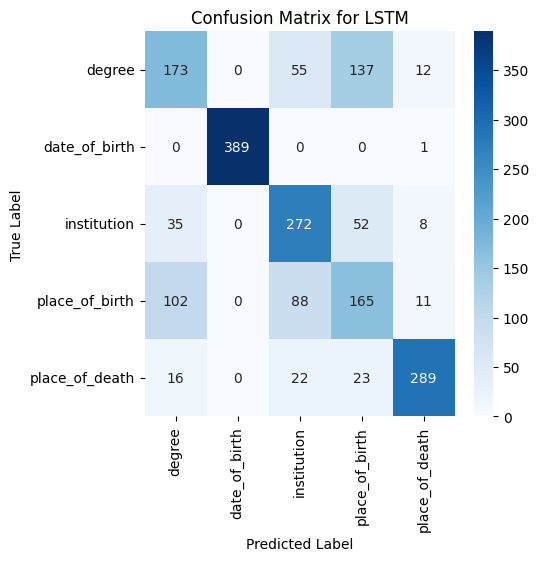

 ----------Result for the learing Rate: 0.001 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.005 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 1.2986
Epoch 2/20, Loss: 0.7922
Epoch 3/20, Loss: 0.5779
Epoch 4/20, Loss: 0.4473
Epoch 5/20, Loss: 0.3488
Epoch 6/20, Loss: 0.2364
Epoch 7/20, Loss: 0.1796
Epoch 8/20, Loss: 0.1109
Epoch 9/20, Loss: 0.1172
Epoch 10/20, Loss: 0.1418
Epoch 11/20, Loss: 0.0682
Epoch 12/20, Loss: 0.0641
Epoch 13/20, Loss: 0.0578
Epoch 14/20, Loss: 0.0429
Epoch 15/20, Loss: 0.0502
Epoch 16/20, Loss: 0.0269
Epoch 17/20, Loss: 0.0328
Epoch 18/20, Loss: 0.0637
Epoch 19/20, Loss: 0.0527
Epoch 20/20, Loss: 0.0314
                precision    recall  f1-score   support

        degree       0.56      0.60      0.58       377
 date_of_birth       1.00      0.99      1.00       390
   institution       0.74      0.64      0.69       367
place_of_birth       0.47      0.51      0.49       366
place_of_death       0.87      0.8

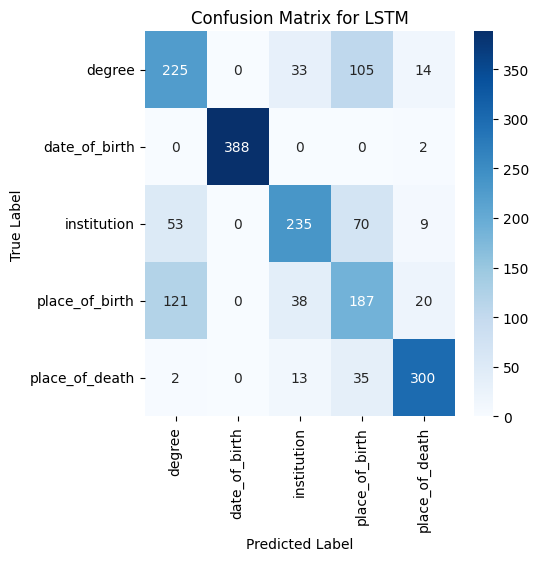

 ----------Result for the learing Rate: 0.005 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.01 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 1.2020
Epoch 2/20, Loss: 0.6712
Epoch 3/20, Loss: 0.5433
Epoch 4/20, Loss: 0.4855
Epoch 5/20, Loss: 0.3959
Epoch 6/20, Loss: 0.3322
Epoch 7/20, Loss: 0.3203
Epoch 8/20, Loss: 0.3092
Epoch 9/20, Loss: 0.3254
Epoch 10/20, Loss: 0.2796
Epoch 11/20, Loss: 0.2719
Epoch 12/20, Loss: 0.2732
Epoch 13/20, Loss: 0.3117
Epoch 14/20, Loss: 0.2629
Epoch 15/20, Loss: 0.2655
Epoch 16/20, Loss: 0.2392
Epoch 17/20, Loss: 0.2044
Epoch 18/20, Loss: 0.2287
Epoch 19/20, Loss: 0.2271
Epoch 20/20, Loss: 0.2119
                precision    recall  f1-score   support

        degree       0.60      0.41      0.49       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.69      0.77      0.73       367
place_of_birth       0.45      0.54      0.49       366
place_of_death       0.88      0.89

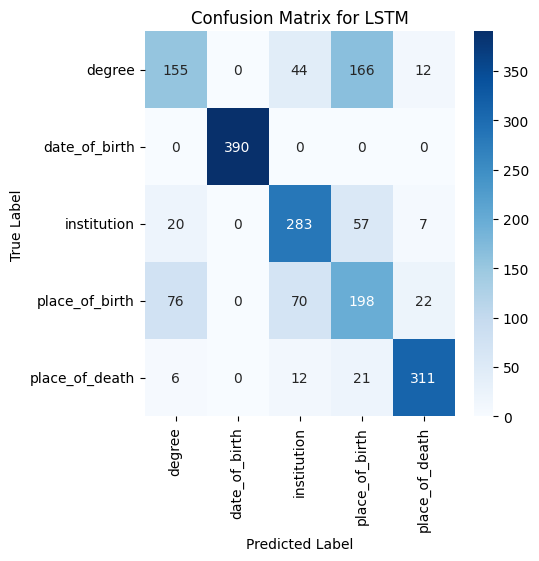

 ----------Result for the learing Rate: 0.01 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.05 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 1.5339
Epoch 2/20, Loss: 1.2823
Epoch 3/20, Loss: 1.1395
Epoch 4/20, Loss: nan
Epoch 5/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 7/20, Loss: nan
Epoch 8/20, Loss: nan
Epoch 9/20, Loss: nan
Epoch 10/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

        degree       0.00      0.00      0.00       377
 date_of_birth       0.21      1.00      0.35       390
   institution       0.00      0.00      0.00       367
place_of_birth       0.00      0.00      0.00       366
place_of_death       0.00      0.00      0.00       350

      accuracy                           0.21      1850
     macro avg       0.04      0.20      0.07      1850
  weighted avg       0.04      0.21      0.07      1850

........................................................ 



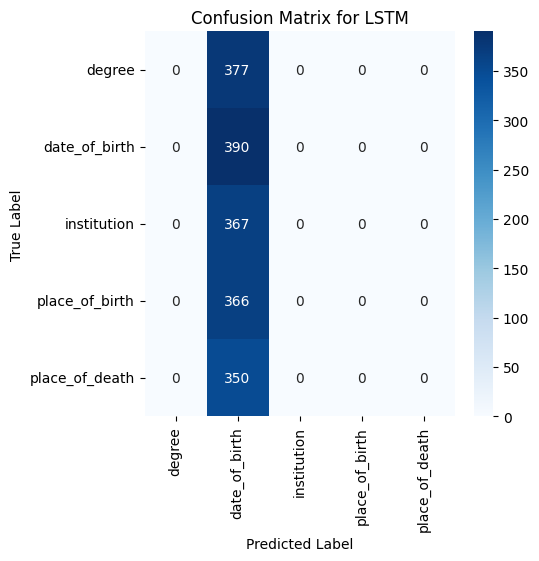

 ----------Result for the learing Rate: 0.05 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.01 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 1.3266
Epoch 2/20, Loss: 0.7594
Epoch 3/20, Loss: 0.6233
Epoch 4/20, Loss: 0.5729
Epoch 5/20, Loss: 0.4943
Epoch 6/20, Loss: 0.4303
Epoch 7/20, Loss: 0.4001
Epoch 8/20, Loss: 0.3595
Epoch 9/20, Loss: 0.3811
Epoch 10/20, Loss: 0.3568
Epoch 11/20, Loss: 0.3329
Epoch 12/20, Loss: 0.2936
Epoch 13/20, Loss: 0.2773
Epoch 14/20, Loss: 0.2808
Epoch 15/20, Loss: 0.2998
Epoch 16/20, Loss: 0.3070
Epoch 17/20, Loss: 0.2790
Epoch 18/20, Loss: 0.2635
Epoch 19/20, Loss: 0.2920
Epoch 20/20, Loss: 0.3272
                precision    recall  f1-score   support

        degree       0.52      0.54      0.53       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.82      0.66      0.73       367
place_of_birth       0.44      0.55      0.49       366
place_of_death       0.93      0.85 

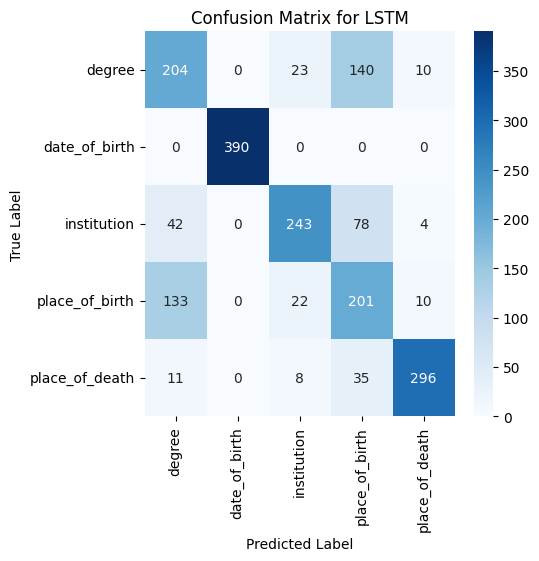

 ----------Result for the learing Rate: 0.01 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.001 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 1.4058
Epoch 2/20, Loss: 0.9527
Epoch 3/20, Loss: 0.7480
Epoch 4/20, Loss: 0.6562
Epoch 5/20, Loss: 0.6927
Epoch 6/20, Loss: 0.7773
Epoch 7/20, Loss: 0.6998
Epoch 8/20, Loss: 0.5564
Epoch 9/20, Loss: 0.4570
Epoch 10/20, Loss: 0.3614
Epoch 11/20, Loss: 0.2656
Epoch 12/20, Loss: 0.1870
Epoch 13/20, Loss: 0.1264
Epoch 14/20, Loss: 0.0930
Epoch 15/20, Loss: 0.0644
Epoch 16/20, Loss: 0.0518
Epoch 17/20, Loss: 0.0439
Epoch 18/20, Loss: 0.0410
Epoch 19/20, Loss: 0.0387
Epoch 20/20, Loss: 0.0245
                precision    recall  f1-score   support

        degree       0.58      0.73      0.64       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.86      0.58      0.69       367
place_of_birth       0.50      0.56      0.53       366
place_of_death       0.91      0.86

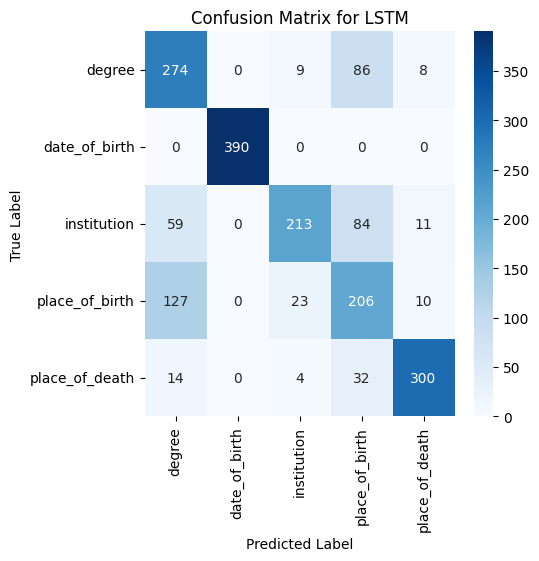

 ----------Result for the learing Rate: 0.001 and hidden_dim: 256 Finished ----------



---------- Result for the learing Rate: 0.005 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 1.3970
Epoch 2/20, Loss: 0.7124
Epoch 3/20, Loss: 0.5139
Epoch 4/20, Loss: 0.4123
Epoch 5/20, Loss: 0.3133
Epoch 6/20, Loss: 0.2405
Epoch 7/20, Loss: 0.1832
Epoch 8/20, Loss: 0.1399
Epoch 9/20, Loss: 0.1366
Epoch 10/20, Loss: 0.0968
Epoch 11/20, Loss: 0.0766
Epoch 12/20, Loss: 0.0575
Epoch 13/20, Loss: 0.0557
Epoch 14/20, Loss: 0.0451
Epoch 15/20, Loss: 0.0557
Epoch 16/20, Loss: 0.0642
Epoch 17/20, Loss: 0.0546
Epoch 18/20, Loss: 0.0518
Epoch 19/20, Loss: 0.0439
Epoch 20/20, Loss: 0.0322
                precision    recall  f1-score   support

        degree       0.58      0.53      0.55       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.79      0.64      0.71       367
place_of_birth       0.49      0.62      0.55       366
place_of_death       0.87      0.8

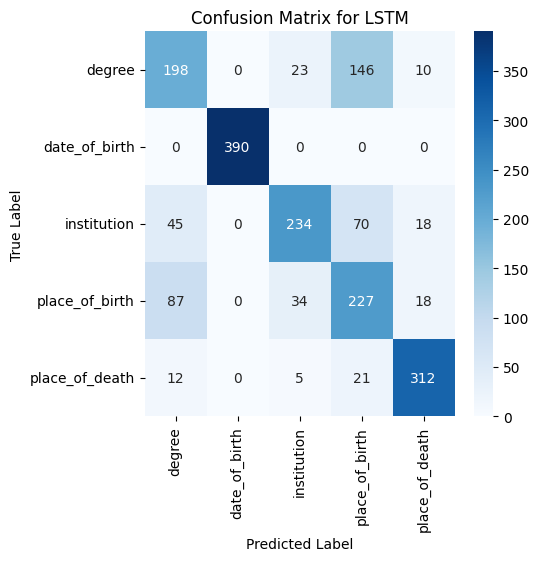

 ----------Result for the learing Rate: 0.005 and hidden_dim: 256 Finished ----------



---------- Result for the learing Rate: 0.01 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 1.2116
Epoch 2/20, Loss: 1.3208
Epoch 3/20, Loss: 1.0909
Epoch 4/20, Loss: 0.8319
Epoch 5/20, Loss: 0.8179
Epoch 6/20, Loss: 0.9632
Epoch 7/20, Loss: 0.7777
Epoch 8/20, Loss: 0.7671
Epoch 9/20, Loss: 0.7106
Epoch 10/20, Loss: 0.6737
Epoch 11/20, Loss: 0.6786
Epoch 12/20, Loss: 0.6828
Epoch 13/20, Loss: 0.6614
Epoch 14/20, Loss: 0.6409
Epoch 15/20, Loss: 0.6614
Epoch 16/20, Loss: 0.6591
Epoch 17/20, Loss: 0.6664
Epoch 18/20, Loss: 0.6485
Epoch 19/20, Loss: 0.6336
Epoch 20/20, Loss: 0.6547
                precision    recall  f1-score   support

        degree       0.59      0.63      0.61       377
 date_of_birth       1.00      0.99      1.00       390
   institution       0.64      0.80      0.71       367
place_of_birth       0.45      0.27      0.34       366
place_of_death       0.84      0.93

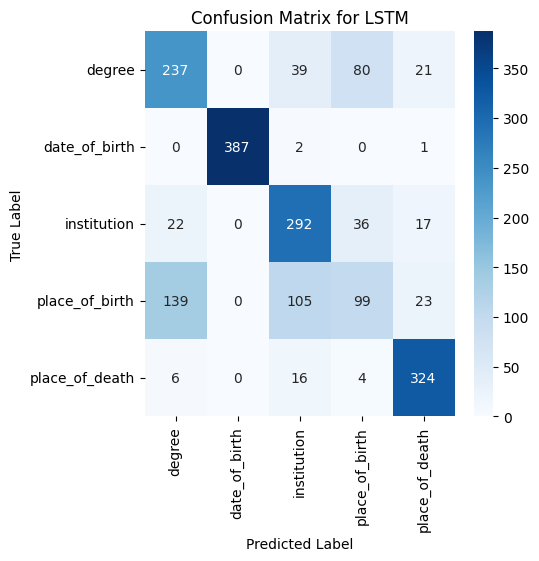

 ----------Result for the learing Rate: 0.01 and hidden_dim: 256 Finished ----------



---------- Result for the learing Rate: 0.05 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: nan
Epoch 2/20, Loss: nan
Epoch 3/20, Loss: nan
Epoch 4/20, Loss: nan
Epoch 5/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 7/20, Loss: nan
Epoch 8/20, Loss: nan
Epoch 9/20, Loss: nan
Epoch 10/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

        degree       0.00      0.00      0.00       377
 date_of_birth       0.21      1.00      0.35       390
   institution       0.00      0.00      0.00       367
place_of_birth       0.00      0.00      0.00       366
place_of_death       0.00      0.00      0.00       350

      accuracy                           0.21      1850
     macro avg       0.04      0.20      0.07      1850
  weighted avg       0.04      0.21      0.07      1850

........................................................ 



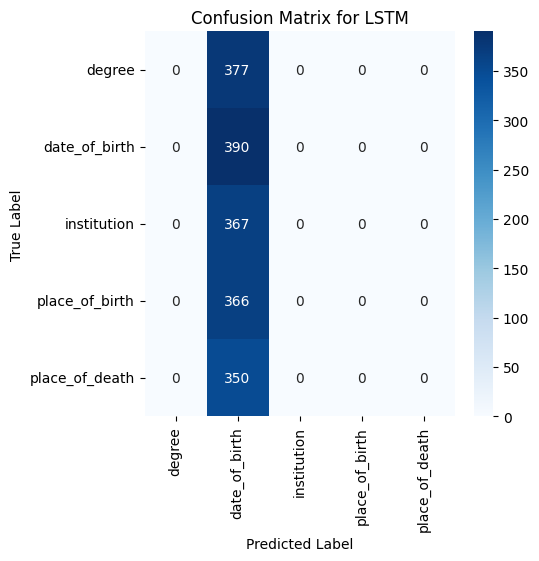

 ----------Result for the learing Rate: 0.05 and hidden_dim: 256 Finished ----------



---------- Result for the learing Rate: 0.01 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 1.2703
Epoch 2/20, Loss: 0.6703
Epoch 3/20, Loss: 0.6023
Epoch 4/20, Loss: 0.5316
Epoch 5/20, Loss: 0.5129
Epoch 6/20, Loss: 0.4715
Epoch 7/20, Loss: 0.4421
Epoch 8/20, Loss: 0.4055
Epoch 9/20, Loss: 0.4529
Epoch 10/20, Loss: 0.7212
Epoch 11/20, Loss: 1.4143
Epoch 12/20, Loss: 1.3657
Epoch 13/20, Loss: 1.3138
Epoch 14/20, Loss: 1.3316
Epoch 15/20, Loss: 1.3681
Epoch 16/20, Loss: 1.4059
Epoch 17/20, Loss: 1.3759
Epoch 18/20, Loss: 1.3559
Epoch 19/20, Loss: 1.3109
Epoch 20/20, Loss: 1.2714
                precision    recall  f1-score   support

        degree       0.35      0.49      0.41       377
 date_of_birth       0.61      0.71      0.66       390
   institution       0.43      0.24      0.31       367
place_of_birth       0.34      0.27      0.30       366
place_of_death       0.74      0.76 

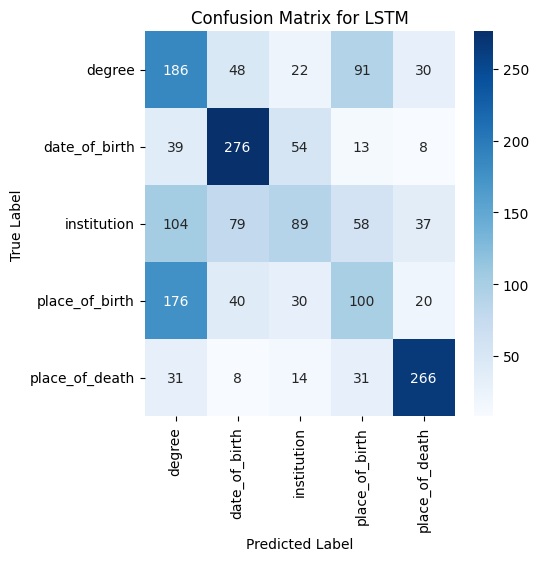

 ----------Result for the learing Rate: 0.01 and hidden_dim: 256 Finished ----------





In [ ]:
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.01]
hidden_dim_list = [128, 256]

for hidden_dim in hidden_dim_list:
    for lr in learning_rate:
        # Initialize the LSTMClassifier model
        embedding_dim = 128
        hidden_dim = hidden_dim
        lstm_model = LSTMClassifier(vocab_size=len(vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=len(unique_labels))

        optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        print(f'---------- Result for the learing Rate: {lr} and hidden_dim: {hidden_dim} Started ----------')
        # Train model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_model(lstm_model, lstm_train_dataloader, optimizer, loss_fn, device, epochs=20, model_type = 'LSTM')

        # evalution
        lstm_true_labels, lstm_preds = evaluate_model(lstm_model, lstm_test_dataloader, device, model_type = 'LSTM')

        # Print classification report and Display the confusion matrix
        plot_classification_report_and_confusion_matrix(lstm_true_labels, lstm_preds, id2label, "LSTM")

        print(f' ----------Result for the learing Rate: {lr} and hidden_dim: {hidden_dim} Finished ----------')
        print('\n\n')


print('\n\n')
print('---------------------- All process finished. ----------------------')

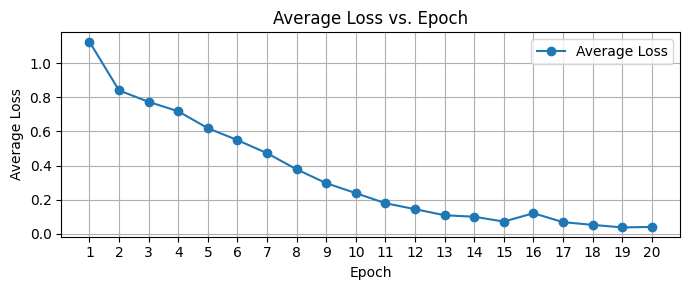

In [ ]:
# Create the plot for Loss and Epoch
plot_loss_vs_epoch(all_epoch, Average_loss,  start=0, end=20)

## ........  5 - 3: **Bidirectional LSTM: Training  and Evaluation** ............

---------- Result for the learing Rate: 0.001 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 0.7780
Epoch 2/20, Loss: 0.5189
Epoch 3/20, Loss: 0.4462
Epoch 4/20, Loss: 0.3313
Epoch 5/20, Loss: 0.2201
Epoch 6/20, Loss: 0.1536
Epoch 7/20, Loss: 0.1038
Epoch 8/20, Loss: 0.0798
Epoch 9/20, Loss: 0.0514
Epoch 10/20, Loss: 0.0412
Epoch 11/20, Loss: 0.0296
Epoch 12/20, Loss: 0.0304
Epoch 13/20, Loss: 0.0397
Epoch 14/20, Loss: 0.0835
Epoch 15/20, Loss: 0.0562
Epoch 16/20, Loss: 0.0269
Epoch 17/20, Loss: 0.0247
Epoch 18/20, Loss: 0.0155
Epoch 19/20, Loss: 0.0216
Epoch 20/20, Loss: 0.0174
                precision    recall  f1-score   support

        degree       0.68      0.67      0.68       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.75      0.72      0.73       367
place_of_birth       0.62      0.73      0.67       366
place_of_death       0.89      0.80      0.85       350

      accuracy                           0.78      1850
     macro

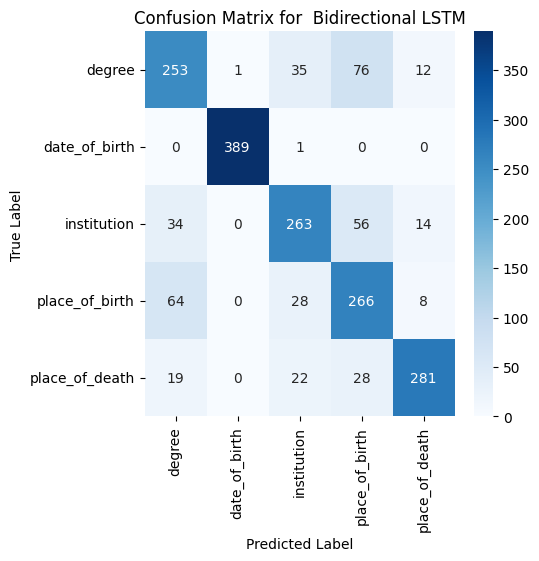



 ----------Result for the learing Rate: 0.001 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.005 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 0.7961
Epoch 2/20, Loss: 0.5702
Epoch 3/20, Loss: 0.3825
Epoch 4/20, Loss: 0.1926
Epoch 5/20, Loss: 0.1005
Epoch 6/20, Loss: 0.0643
Epoch 7/20, Loss: 0.0537
Epoch 8/20, Loss: 0.0661
Epoch 9/20, Loss: 0.0666
Epoch 10/20, Loss: 0.0526
Epoch 11/20, Loss: 0.0336
Epoch 12/20, Loss: 0.0226
Epoch 13/20, Loss: 0.0164
Epoch 14/20, Loss: 0.0160
Epoch 15/20, Loss: 0.0193
Epoch 16/20, Loss: 0.0977
Epoch 17/20, Loss: 0.0578
Epoch 18/20, Loss: 0.0302
Epoch 19/20, Loss: 0.0177
Epoch 20/20, Loss: 0.0251
                precision    recall  f1-score   support

        degree       0.67      0.55      0.61       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.67      0.82      0.74       367
place_of_birth       0.56      0.53      0.55       366
place_of_death       0.86      0

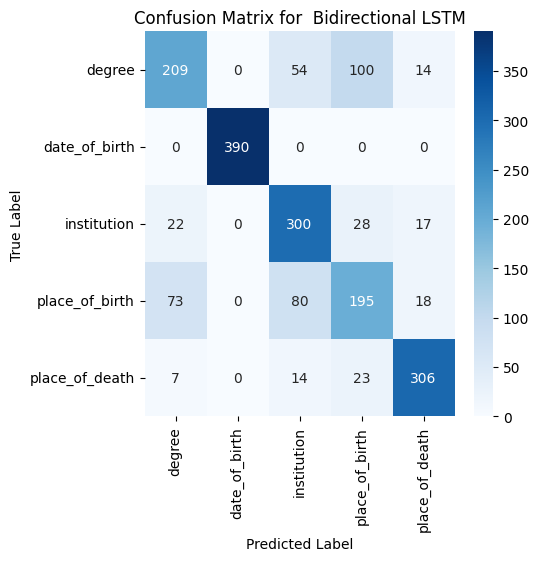



 ----------Result for the learing Rate: 0.005 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.01 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 0.9064
Epoch 2/20, Loss: 0.5229
Epoch 3/20, Loss: 0.4225
Epoch 4/20, Loss: 0.3061
Epoch 5/20, Loss: 0.2354
Epoch 6/20, Loss: 0.2200
Epoch 7/20, Loss: 0.2111
Epoch 8/20, Loss: 0.1802
Epoch 9/20, Loss: 0.1774
Epoch 10/20, Loss: 0.3047
Epoch 11/20, Loss: 0.6177
Epoch 12/20, Loss: 0.6354
Epoch 13/20, Loss: 0.5515
Epoch 14/20, Loss: 0.5371
Epoch 15/20, Loss: 0.4676
Epoch 16/20, Loss: 0.4403
Epoch 17/20, Loss: 0.4291
Epoch 18/20, Loss: 0.4082
Epoch 19/20, Loss: 0.4977
Epoch 20/20, Loss: 0.8059
                precision    recall  f1-score   support

        degree       0.47      0.42      0.44       377
 date_of_birth       0.96      0.88      0.92       390
   institution       0.63      0.50      0.56       367
place_of_birth       0.39      0.51      0.44       366
place_of_death       0.67      0.

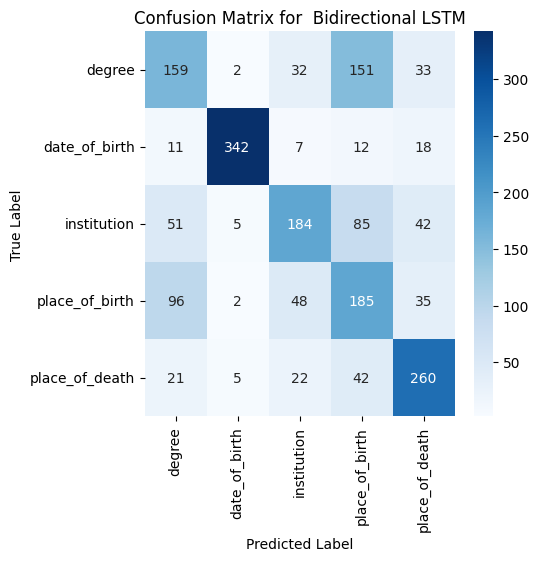



 ----------Result for the learing Rate: 0.01 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.05 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: nan
Epoch 2/20, Loss: nan
Epoch 3/20, Loss: nan
Epoch 4/20, Loss: nan
Epoch 5/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 7/20, Loss: nan
Epoch 8/20, Loss: nan
Epoch 9/20, Loss: nan
Epoch 10/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

        degree       0.00      0.00      0.00       377
 date_of_birth       0.21      1.00      0.35       390
   institution       0.00      0.00      0.00       367
place_of_birth       0.00      0.00      0.00       366
place_of_death       0.00      0.00      0.00       350

      accuracy                           0.21      1850
     macro avg       0.04      0.20      0.07      1850
  weighted avg       0.04      0.21      0.07      1850

........................................................ 



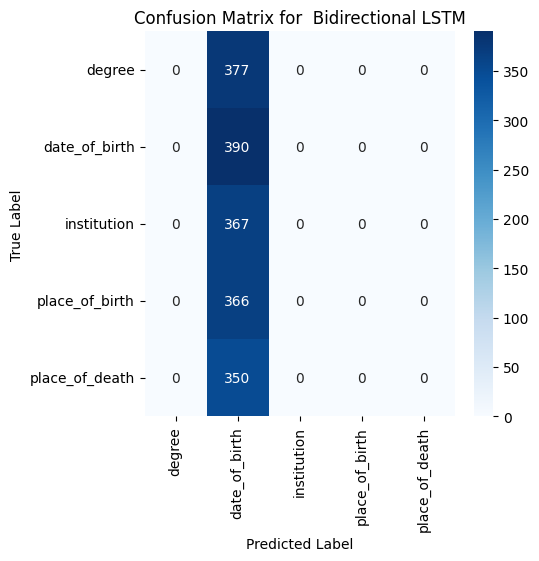



 ----------Result for the learing Rate: 0.05 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.01 and hidden_dim: 128 Started ----------
Epoch 1/20, Loss: 0.8379
Epoch 2/20, Loss: 0.5231
Epoch 3/20, Loss: 0.3877
Epoch 4/20, Loss: 0.3216
Epoch 5/20, Loss: 0.3442
Epoch 6/20, Loss: 0.2952
Epoch 7/20, Loss: 0.2022
Epoch 8/20, Loss: 0.1740
Epoch 9/20, Loss: 0.1741
Epoch 10/20, Loss: 0.2037
Epoch 11/20, Loss: 0.2230
Epoch 12/20, Loss: 0.1834
Epoch 13/20, Loss: 0.2062
Epoch 14/20, Loss: 0.2258
Epoch 15/20, Loss: 0.2262
Epoch 16/20, Loss: 0.2530
Epoch 17/20, Loss: 0.2303
Epoch 18/20, Loss: 0.2441
Epoch 19/20, Loss: 0.2396
Epoch 20/20, Loss: 0.2299
                precision    recall  f1-score   support

        degree       0.65      0.59      0.62       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.71      0.76      0.73       367
place_of_birth       0.58      0.55      0.56       366
place_of_death       0.86      0.9

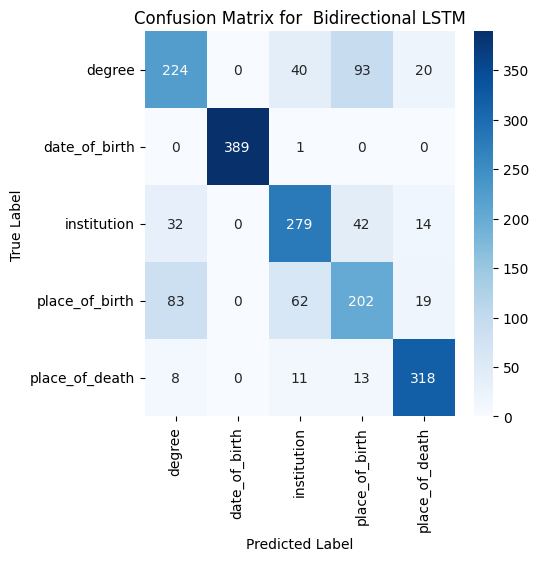



 ----------Result for the learing Rate: 0.01 and hidden_dim: 128 Finished ----------



---------- Result for the learing Rate: 0.001 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 0.7682
Epoch 2/20, Loss: 0.5302
Epoch 3/20, Loss: 0.3957
Epoch 4/20, Loss: 0.3002
Epoch 5/20, Loss: 0.1983
Epoch 6/20, Loss: 0.1128
Epoch 7/20, Loss: 0.0787
Epoch 8/20, Loss: 0.0549
Epoch 9/20, Loss: 0.0369
Epoch 10/20, Loss: 0.0238
Epoch 11/20, Loss: 0.3241
Epoch 12/20, Loss: 0.0628
Epoch 13/20, Loss: 0.0221
Epoch 14/20, Loss: 0.0123
Epoch 15/20, Loss: 0.0605
Epoch 16/20, Loss: 0.0155
Epoch 17/20, Loss: 0.0143
Epoch 18/20, Loss: 0.0086
Epoch 19/20, Loss: 0.0079
Epoch 20/20, Loss: 0.0085
                precision    recall  f1-score   support

        degree       0.69      0.68      0.68       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.80      0.80      0.80       367
place_of_birth       0.65      0.66      0.65       366
place_of_death       0.90      0.

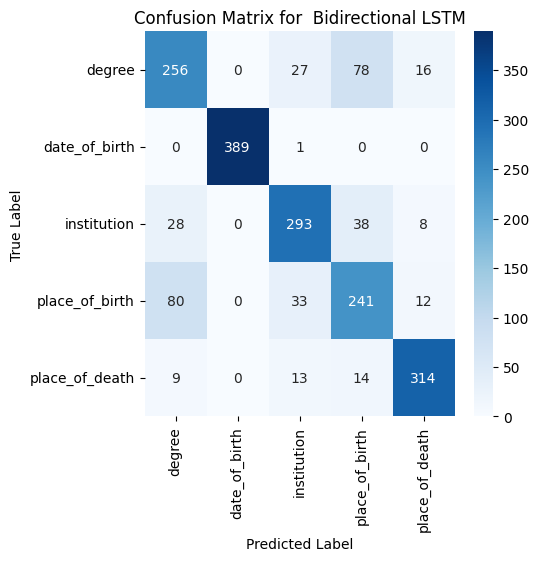



 ----------Result for the learing Rate: 0.001 and hidden_dim: 256 Finished ----------



---------- Result for the learing Rate: 0.005 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 1.2565
Epoch 2/20, Loss: 0.8631
Epoch 3/20, Loss: 0.5747
Epoch 4/20, Loss: 0.4482
Epoch 5/20, Loss: 0.3173
Epoch 6/20, Loss: 0.2126
Epoch 7/20, Loss: 0.1437
Epoch 8/20, Loss: 0.1065
Epoch 9/20, Loss: 0.0856
Epoch 10/20, Loss: 0.0709
Epoch 11/20, Loss: 0.0559
Epoch 12/20, Loss: 0.0523
Epoch 13/20, Loss: 0.0446
Epoch 14/20, Loss: 0.0388
Epoch 15/20, Loss: 0.0310
Epoch 16/20, Loss: 0.0320
Epoch 17/20, Loss: 0.0424
Epoch 18/20, Loss: 0.0306
Epoch 19/20, Loss: 0.0411
Epoch 20/20, Loss: 0.0414
                precision    recall  f1-score   support

        degree       0.48      0.68      0.56       377
 date_of_birth       1.00      0.99      0.99       390
   institution       0.84      0.56      0.67       367
place_of_birth       0.48      0.49      0.48       366
place_of_death       0.94      0

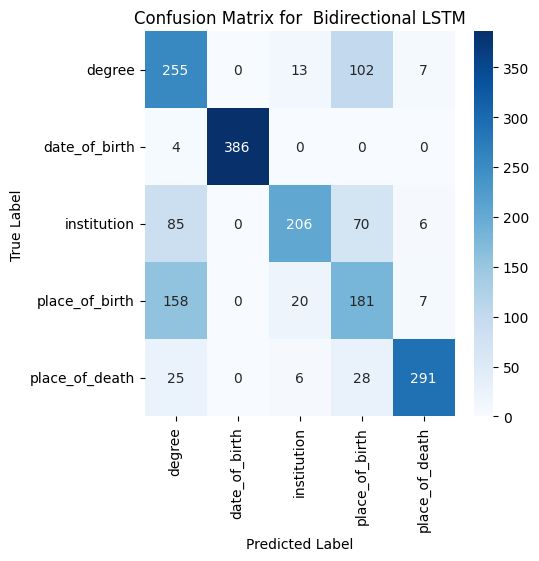



 ----------Result for the learing Rate: 0.005 and hidden_dim: 256 Finished ----------



---------- Result for the learing Rate: 0.01 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 0.8866
Epoch 2/20, Loss: 0.5936
Epoch 3/20, Loss: 0.5687
Epoch 4/20, Loss: 0.6873
Epoch 5/20, Loss: 0.8805
Epoch 6/20, Loss: 0.5161
Epoch 7/20, Loss: 0.4028
Epoch 8/20, Loss: 0.3330
Epoch 9/20, Loss: 0.2853
Epoch 10/20, Loss: 0.3882
Epoch 11/20, Loss: 0.5239
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

        degree       0.00      0.00      0.00       377
 date_of_birth       0.21      1.00      0.35       390
   institution       0.00      0.00      0.00       367
place_of_birth       0.00      0.00      0.00       366
place_of_death       0.00      0.00      0.00       350

      accuracy                           0.21      1850
     macro avg       0.04      0.20      0.07      1850
  weighted avg       0.04      0.21      0.07      1850

........................................................ 



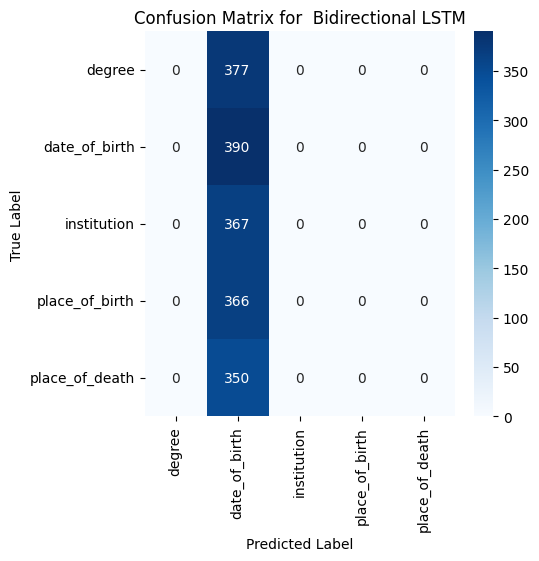



 ----------Result for the learing Rate: 0.01 and hidden_dim: 256 Finished ----------



---------- Result for the learing Rate: 0.05 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 2.5795
Epoch 2/20, Loss: nan
Epoch 3/20, Loss: nan
Epoch 4/20, Loss: nan
Epoch 5/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 7/20, Loss: nan
Epoch 8/20, Loss: nan
Epoch 9/20, Loss: nan
Epoch 10/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

        degree       0.00      0.00      0.00       377
 date_of_birth       0.21      1.00      0.35       390
   institution       0.00      0.00      0.00       367
place_of_birth       0.00      0.00      0.00       366
place_of_death       0.00      0.00      0.00       350

      accuracy                           0.21      1850
     macro avg       0.04      0.20      0.07      1850
  weighted avg       0.04      0.21      0.07      1850

........................................................ 



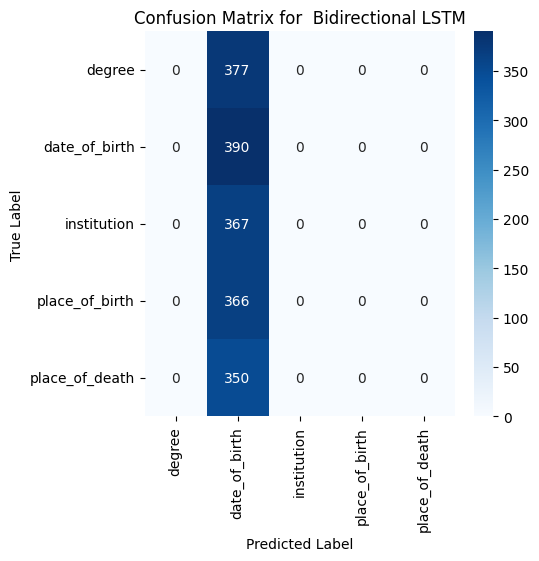



 ----------Result for the learing Rate: 0.05 and hidden_dim: 256 Finished ----------



---------- Result for the learing Rate: 0.01 and hidden_dim: 256 Started ----------
Epoch 1/20, Loss: 0.8152
Epoch 2/20, Loss: 0.8148
Epoch 3/20, Loss: 0.6688
Epoch 4/20, Loss: 0.5770
Epoch 5/20, Loss: 0.5005
Epoch 6/20, Loss: 0.4581
Epoch 7/20, Loss: 0.3895
Epoch 8/20, Loss: 0.3681
Epoch 9/20, Loss: 0.3134
Epoch 10/20, Loss: 0.3458
Epoch 11/20, Loss: 0.5261
Epoch 12/20, Loss: 0.5836
Epoch 13/20, Loss: 0.4816
Epoch 14/20, Loss: 0.4441
Epoch 15/20, Loss: 0.4146
Epoch 16/20, Loss: 0.4053
Epoch 17/20, Loss: 0.3984
Epoch 18/20, Loss: 0.3846
Epoch 19/20, Loss: 0.3804
Epoch 20/20, Loss: 0.3702
                precision    recall  f1-score   support

        degree       0.48      0.83      0.61       377
 date_of_birth       1.00      1.00      1.00       390
   institution       0.78      0.71      0.74       367
place_of_birth       0.57      0.30      0.39       366
place_of_death       0.96      0.8

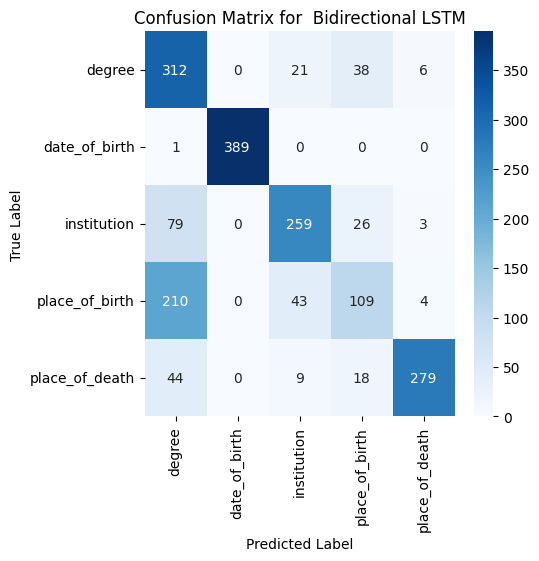



 ----------Result for the learing Rate: 0.01 and hidden_dim: 256 Finished ----------






---------------------- All process finished. ----------------------


In [ ]:
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.01]
hidden_dim_list = [128, 256]

for hidden_dim in hidden_dim_list:
    for lr in learning_rate:
        embedding_dim = 128
        hidden_dim = hidden_dim
        bilstm_model = BiLSTMClassifier(vocab_size=len(vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=len(unique_labels))

        optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        print(f'---------- Result for the learing Rate: {lr} and hidden_dim: {hidden_dim} Started ----------')
        # Train model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_model(bilstm_model, lstm_train_dataloader, optimizer, loss_fn, device, epochs=20, model_type = 'LSTM')

        # evalution
        bi_lstm_true_labels, bi_lstm_preds = evaluate_model(bilstm_model, lstm_test_dataloader, device, model_type = 'LSTM')

        # Print classification report and Display the confusion matrix
        plot_classification_report_and_confusion_matrix(bi_lstm_true_labels, bi_lstm_preds, id2label, " Bidirectional LSTM")
        print('\n')
        print(f' ----------Result for the learing Rate: {lr} and hidden_dim: {hidden_dim} Finished ----------')
        print('\n\n')


print('\n\n')
print('---------------------- All process finished. ----------------------')

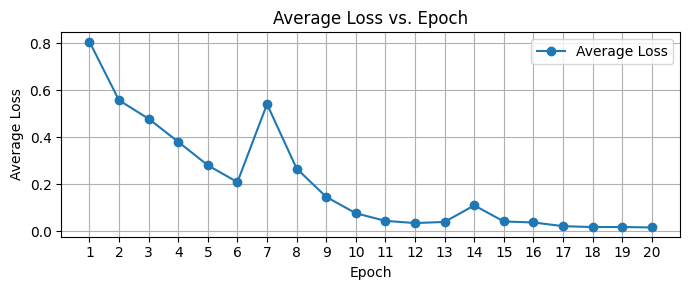

In [ ]:
plot_loss_vs_epoch(all_epoch, Average_loss,  start=20, end=40)

## ........  5 - 4: **Data Preparation for BERT Models** ............

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Testing tokenizer
tokenizer("Hello World") 

# sentence example : result creates format of: [CLS] + sentence + [SEP]

{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer("Hello World , How are you") # sentence example

{'input_ids': [101, 7592, 2088, 1010, 2129, 2024, 2017, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
def prepare_data_for_bert(sentences, labels, tokenizer):
    encodings = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt', max_length=128)
    labels = torch.tensor(labels)

    return encodings, labels

# Prepare training and testing data for BERT
train_encodings, train_labels = prepare_data_for_bert(X_train, y_train, tokenizer)  # dictionary
test_encodings, test_labels = prepare_data_for_bert(X_test, y_test, tokenizer)

# Convert to tensors
train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']
train_labels = train_labels

test_input_ids = test_encodings['input_ids']
test_attention_mask = test_encodings['attention_mask']
test_labels = test_labels


# Create TensorDatasets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

In [ ]:
len(train_encodings)

3

In [ ]:
train_encodings

{'input_ids': tensor([[  101,  2852,  1012,  ...,     0,     0,     0],
        [  101,  4789,  1043,  ...,     0,     0,     0],
        [  101,  8785,  2121,  ...,     0,     0,     0],
        ...,
        [  101, 19604,  3044,  ...,     0,     0,     0],
        [  101,  2332,  2351,  ...,     0,     0,     0],
        [  101,  8233,  1005,  ...,  2176,  2086,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [ ]:
train_encodings['input_ids']

tensor([[  101,  2852,  1012,  ...,     0,     0,     0],
        [  101,  4789,  1043,  ...,     0,     0,     0],
        [  101,  8785,  2121,  ...,     0,     0,     0],
        ...,
        [  101, 19604,  3044,  ...,     0,     0,     0],
        [  101,  2332,  2351,  ...,     0,     0,     0],
        [  101,  8233,  1005,  ...,  2176,  2086,   102]])

In [ ]:
train_encodings['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])

In [ ]:
train_dataset[0]

(tensor([  101,  2852,  1012,  6152,  9586, 24405,  2290,  1006,  1016,  2337,
          8204,  1011,  1011,  1015,  2089,  4554,  1007,  2001,  1037,  4069,
          2148,  2827,  2966, 18742,  2141,  1999,  2167,  7364,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
# Create DataLoaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## ........  5 - 5: **BERT: Training  and Evaluation** ............

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

---------- Result for the   learing Rate: 1e-05 and   Epoch number: 4 Started ----------
Epoch 1/4, Loss: 0.7452
Epoch 2/4, Loss: 0.3529
Epoch 3/4, Loss: 0.2549
Epoch 4/4, Loss: 0.1848
                precision    recall  f1-score   support

   institution       0.84      0.82      0.83       380
        degree       1.00      0.98      0.99       342
place_of_death       0.79      0.91      0.84       352
place_of_birth       0.80      0.74      0.77       387
 date_of_birth       0.93      0.91      0.92       389

      accuracy                           0.87      1850
     macro avg       0.87      0.87      0.87      1850
  weighted avg       0.87      0.87      0.87      1850

........................................................ 



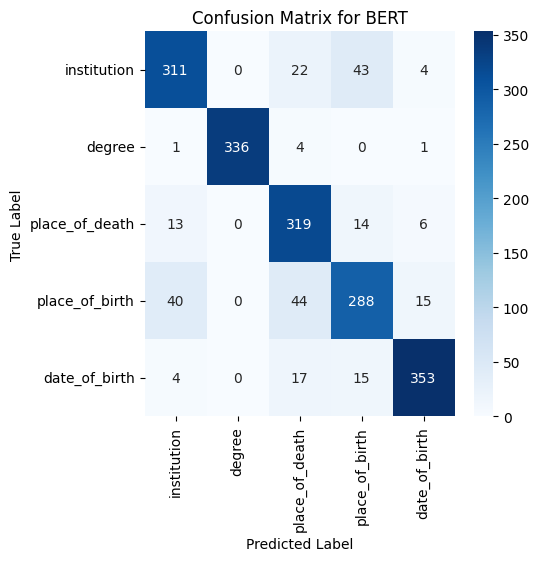

 ----------Result for the   learing Rate: 1e-05 and   Epoch number: 4 Finished ----------



---------- Result for the   learing Rate: 0.0001 and   Epoch number: 4 Started ----------
Epoch 1/4, Loss: 0.5600
Epoch 2/4, Loss: 0.3777
Epoch 3/4, Loss: 0.3007
Epoch 4/4, Loss: 0.2588
                precision    recall  f1-score   support

   institution       0.78      0.82      0.80       380
        degree       0.99      0.99      0.99       342
place_of_death       0.87      0.85      0.86       352
place_of_birth       0.79      0.74      0.76       387
 date_of_birth       0.88      0.93      0.90       389

      accuracy                           0.86      1850
     macro avg       0.86      0.86      0.86      1850
  weighted avg       0.86      0.86      0.86      1850

........................................................ 



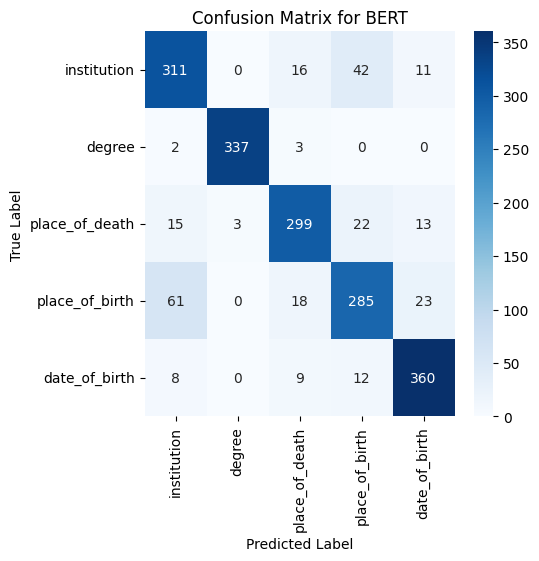

 ----------Result for the   learing Rate: 0.0001 and   Epoch number: 4 Finished ----------



---------- Result for the   learing Rate: 0.001 and   Epoch number: 4 Started ----------
Epoch 1/4, Loss: 1.7098
Epoch 2/4, Loss: 1.6925
Epoch 3/4, Loss: 1.6803
Epoch 4/4, Loss: 1.6850


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

   institution       0.00      0.00      0.00       380
        degree       0.00      0.00      0.00       342
place_of_death       0.00      0.00      0.00       352
place_of_birth       0.21      1.00      0.35       387
 date_of_birth       0.00      0.00      0.00       389

      accuracy                           0.21      1850
     macro avg       0.04      0.20      0.07      1850
  weighted avg       0.04      0.21      0.07      1850

........................................................ 



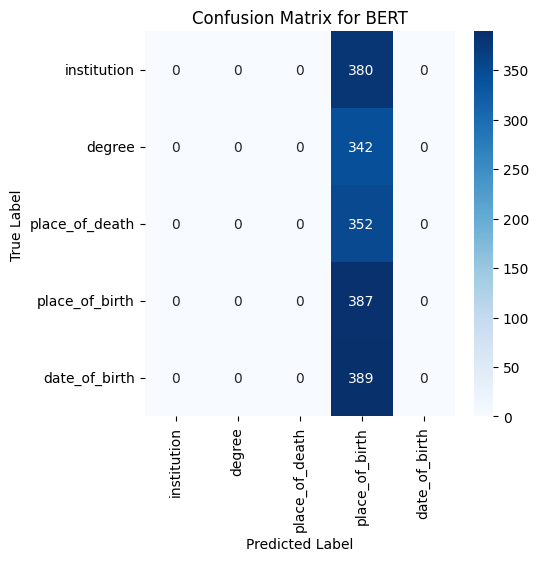

 ----------Result for the   learing Rate: 0.001 and   Epoch number: 4 Finished ----------



---------- Result for the   learing Rate: 1e-05 and   Epoch number: 5 Started ----------
Epoch 1/5, Loss: 0.7165
Epoch 2/5, Loss: 0.3334
Epoch 3/5, Loss: 0.2431
Epoch 4/5, Loss: 0.1739
Epoch 5/5, Loss: 0.1199
                precision    recall  f1-score   support

   institution       0.83      0.85      0.84       380
        degree       1.00      0.99      0.99       342
place_of_death       0.86      0.84      0.85       352
place_of_birth       0.81      0.80      0.80       387
 date_of_birth       0.91      0.93      0.92       389

      accuracy                           0.88      1850
     macro avg       0.88      0.88      0.88      1850
  weighted avg       0.88      0.88      0.88      1850

........................................................ 



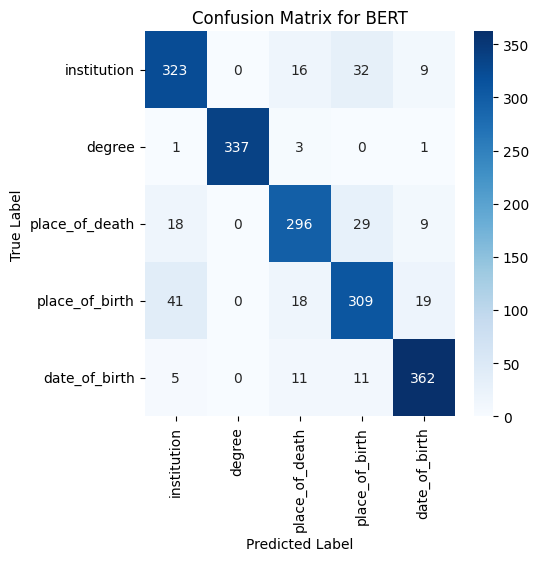

 ----------Result for the   learing Rate: 1e-05 and   Epoch number: 5 Finished ----------



---------- Result for the   learing Rate: 0.0001 and   Epoch number: 5 Started ----------
Epoch 1/5, Loss: 0.5885
Epoch 2/5, Loss: 0.4054
Epoch 3/5, Loss: 0.3676
Epoch 4/5, Loss: 0.3138
Epoch 5/5, Loss: 0.2735
                precision    recall  f1-score   support

   institution       0.81      0.77      0.79       380
        degree       1.00      0.98      0.99       342
place_of_death       0.86      0.76      0.81       352
place_of_birth       0.71      0.82      0.76       387
 date_of_birth       0.90      0.91      0.91       389

      accuracy                           0.85      1850
     macro avg       0.86      0.85      0.85      1850
  weighted avg       0.85      0.85      0.85      1850

........................................................ 



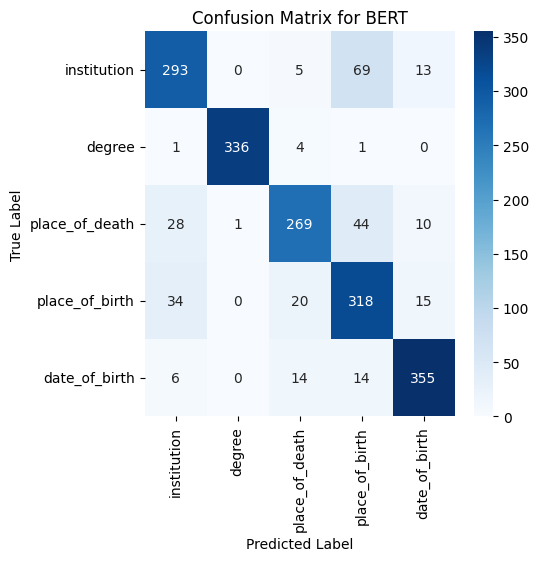

 ----------Result for the   learing Rate: 0.0001 and   Epoch number: 5 Finished ----------



---------- Result for the   learing Rate: 0.001 and   Epoch number: 5 Started ----------
Epoch 1/5, Loss: 1.6878
Epoch 2/5, Loss: 1.6871
Epoch 3/5, Loss: 1.6997
Epoch 4/5, Loss: 1.6940
Epoch 5/5, Loss: 1.6766


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

   institution       0.00      0.00      0.00       380
        degree       0.18      1.00      0.31       342
place_of_death       0.00      0.00      0.00       352
place_of_birth       0.00      0.00      0.00       387
 date_of_birth       0.00      0.00      0.00       389

      accuracy                           0.18      1850
     macro avg       0.04      0.20      0.06      1850
  weighted avg       0.03      0.18      0.06      1850

........................................................ 



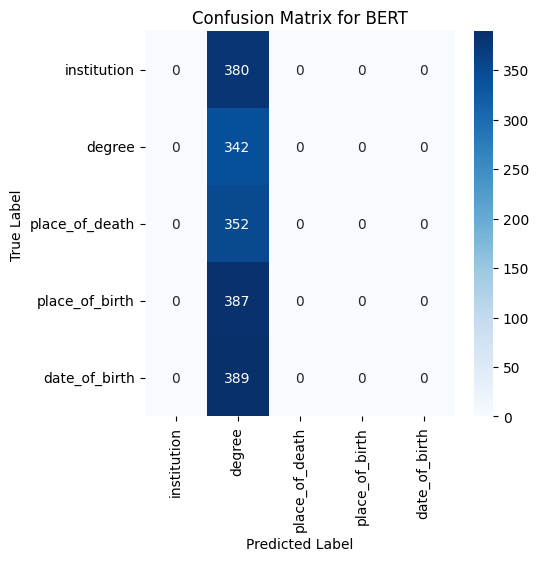

 ----------Result for the   learing Rate: 0.001 and   Epoch number: 5 Finished ----------






---------------------- All process finished. ----------------------


In [38]:
learning_rate = [0.00001, 0.0001, 0.001]
epoch_numers = [4, 5]

for epoch_num in epoch_numers:
    for lr in learning_rate:
        # Initialize the model
        model = BERTClassifier(num_labels=len(unique_labels))
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        print(f'---------- Result for the   learing Rate: {lr} and   Epoch number: {epoch_num} Started ----------')
        # Training model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_model(model, train_dataloader, optimizer, loss_fn, device, epochs=epoch_num, model_type = 'BERT')

        # Evalute model
        bert_true_labels, bert_predict = evaluate_model(model, test_dataloader, device, model_type = 'BERT')

        # Print classification report and Display the confusion matrix
        plot_classification_report_and_confusion_matrix(bert_true_labels, bert_predict, id2label, "BERT")

        print(f' ----------Result for the   learing Rate: {lr} and   Epoch number: {epoch_num} Finished ----------')
        print('\n\n')

print('\n\n')
print('---------------------- All process finished. ----------------------')

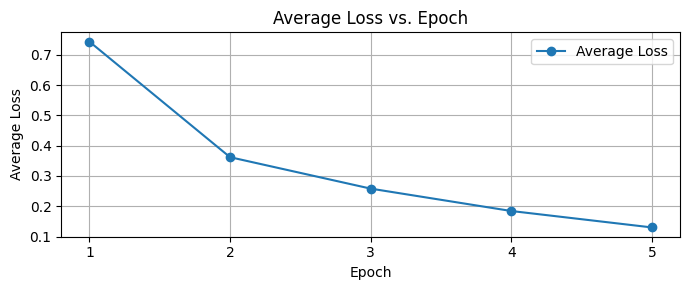

In [ ]:
plot_loss_vs_epoch(all_epoch, Average_loss,  start= 40, end= 45)

## ........  5 - 6: **BERT_Larg: Training  and Evaluation** ............

---------- Result for the   learing Rate: 1e-05 and   Epoch number: 4 Started ----------
Epoch 1/4, Loss: 0.9786
Epoch 2/4, Loss: 0.4729
Epoch 3/4, Loss: 0.3203
Epoch 4/4, Loss: 0.2314
                precision    recall  f1-score   support

 date_of_birth       0.80      0.89      0.84       366
        degree       1.00      0.97      0.99       366
place_of_birth       0.85      0.87      0.86       363
place_of_death       0.82      0.79      0.80       389
   institution       0.95      0.90      0.92       366

      accuracy                           0.88      1850
     macro avg       0.88      0.88      0.88      1850
  weighted avg       0.88      0.88      0.88      1850

........................................................ 



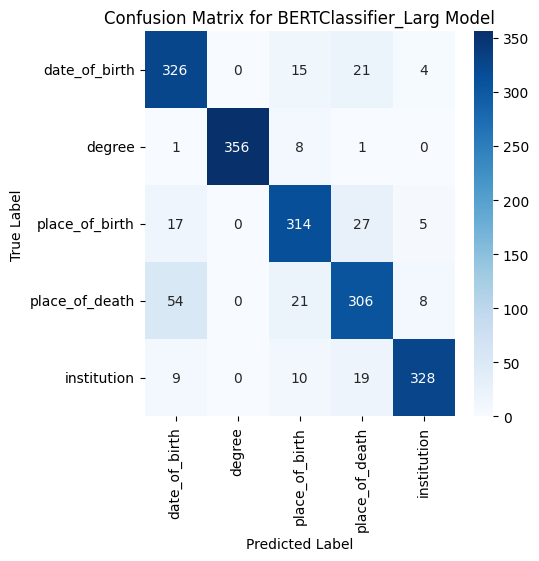

 ----------Result for the   learing Rate: 1e-05 and   Epoch number: 4 Finished ----------



---------- Result for the   learing Rate: 0.0001 and   Epoch number: 4 Started ----------
Epoch 1/4, Loss: 0.7126
Epoch 2/4, Loss: 0.4599
Epoch 3/4, Loss: 0.4281
Epoch 4/4, Loss: 0.3926
                precision    recall  f1-score   support

 date_of_birth       0.86      0.70      0.77       366
        degree       1.00      0.97      0.99       366
place_of_birth       0.83      0.85      0.84       363
place_of_death       0.67      0.86      0.76       389
   institution       0.94      0.84      0.88       366

      accuracy                           0.84      1850
     macro avg       0.86      0.84      0.85      1850
  weighted avg       0.86      0.84      0.85      1850

........................................................ 



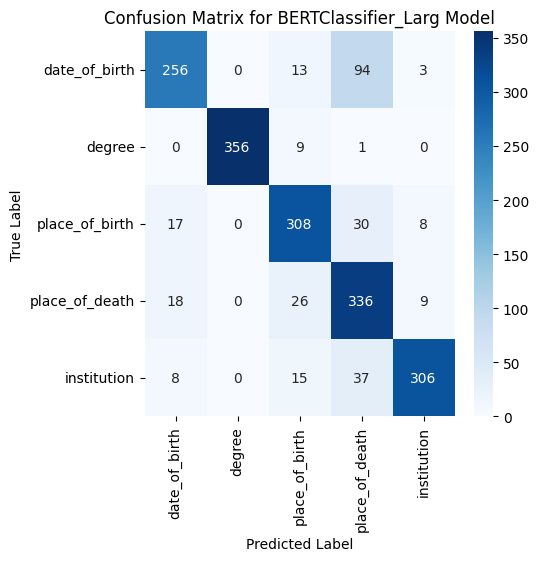

 ----------Result for the   learing Rate: 0.0001 and   Epoch number: 4 Finished ----------



---------- Result for the   learing Rate: 0.001 and   Epoch number: 4 Started ----------
Epoch 1/4, Loss: 1.6188
Epoch 2/4, Loss: 1.6102
Epoch 3/4, Loss: 1.6097
Epoch 4/4, Loss: 1.6099


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

 date_of_birth       0.00      0.00      0.00       366
        degree       0.00      0.00      0.00       366
place_of_birth       0.00      0.00      0.00       363
place_of_death       0.00      0.00      0.00       389
   institution       0.20      1.00      0.33       366

      accuracy                           0.20      1850
     macro avg       0.04      0.20      0.07      1850
  weighted avg       0.04      0.20      0.07      1850

........................................................ 



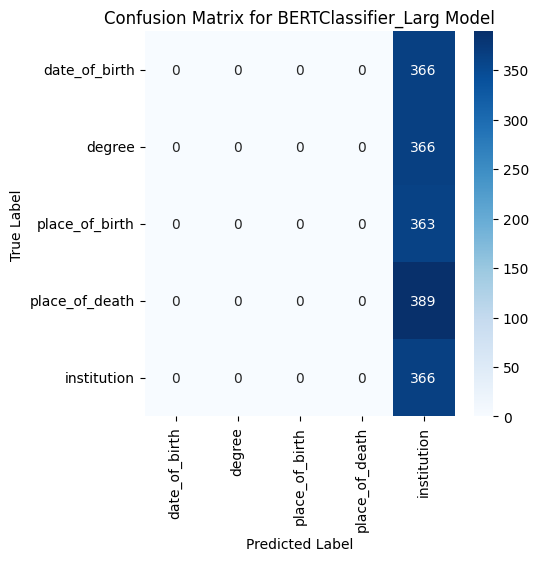

 ----------Result for the   learing Rate: 0.001 and   Epoch number: 4 Finished ----------



---------- Result for the   learing Rate: 1e-05 and   Epoch number: 5 Started ----------
Epoch 1/5, Loss: 0.9562
Epoch 2/5, Loss: 0.4844
Epoch 3/5, Loss: 0.3346
Epoch 4/5, Loss: 0.2453
Epoch 5/5, Loss: 0.1741
                precision    recall  f1-score   support

 date_of_birth       0.86      0.83      0.84       366
        degree       1.00      0.97      0.98       366
place_of_birth       0.82      0.89      0.85       363
place_of_death       0.80      0.83      0.81       389
   institution       0.96      0.91      0.93       366

      accuracy                           0.88      1850
     macro avg       0.89      0.88      0.89      1850
  weighted avg       0.89      0.88      0.88      1850

........................................................ 



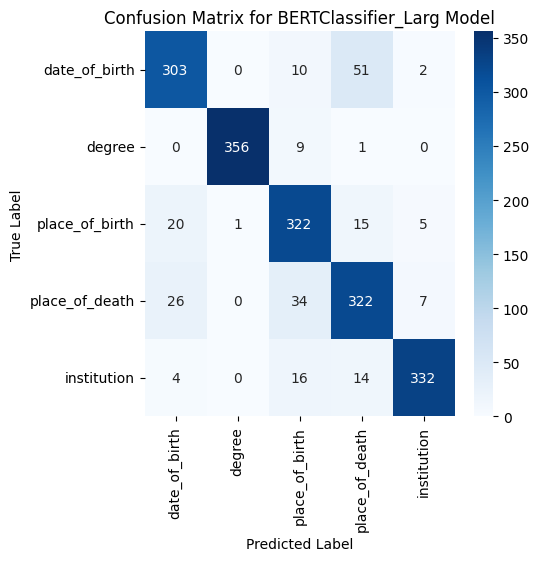

 ----------Result for the   learing Rate: 1e-05 and   Epoch number: 5 Finished ----------



---------- Result for the   learing Rate: 0.0001 and   Epoch number: 5 Started ----------
Epoch 1/5, Loss: 0.6382
Epoch 2/5, Loss: 0.4033
Epoch 3/5, Loss: 0.3667
Epoch 4/5, Loss: 0.5581
Epoch 5/5, Loss: 0.3799
                precision    recall  f1-score   support

 date_of_birth       0.74      0.79      0.76       366
        degree       0.93      0.97      0.95       366
place_of_birth       0.72      0.67      0.70       363
place_of_death       0.66      0.75      0.71       389
   institution       0.82      0.65      0.72       366

      accuracy                           0.77      1850
     macro avg       0.77      0.77      0.77      1850
  weighted avg       0.77      0.77      0.77      1850

........................................................ 



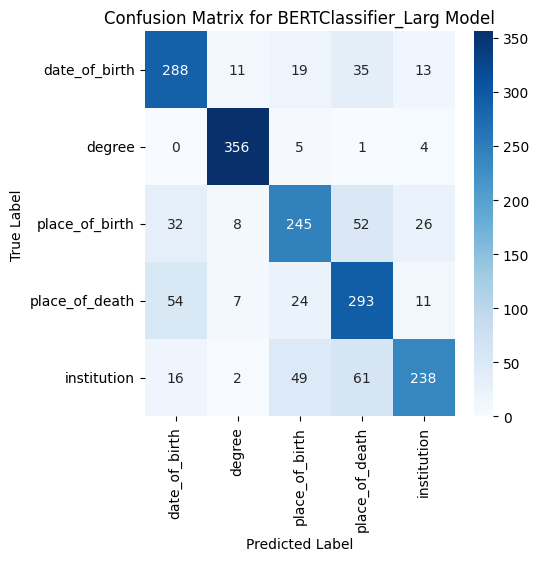

 ----------Result for the   learing Rate: 0.0001 and   Epoch number: 5 Finished ----------



---------- Result for the   learing Rate: 0.001 and   Epoch number: 5 Started ----------
Epoch 1/5, Loss: 1.6166
Epoch 2/5, Loss: 1.6099
Epoch 3/5, Loss: 1.6097


In [ ]:
learning_rate = [0.00001, 0.0001, 0.001]
epoch_numers = [4, 5]

for epoch_num in epoch_numers:
    for lr in learning_rate:
        # Initialize the model
        model_B_L = BERTClassifier_Larg(num_labels=len(unique_labels))
        optimizer = torch.optim.AdamW(model_B_L.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        print(f'---------- Result for the   learing Rate: {lr} and   Epoch number: {epoch_num} Started ----------')
        # Training model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_model(model_B_L, train_dataloader, optimizer, loss_fn, device, epochs=epoch_num, model_type = 'BERT')

        # Evalute model
        bert_true_labels, bert_predict = evaluate_model(model_B_L, test_dataloader, device, model_type = 'BERT')

        # Print classification report and Display the confusion matrix
        plot_classification_report_and_confusion_matrix(bert_true_labels, bert_predict, id2label, "BERTClassifier_Larg Model")

        print(f' ----------Result for the   learing Rate: {lr} and   Epoch number: {epoch_num} Finished ----------')
        print('\n\n')

print('\n\n')
print('---------------------- All process finished. ----------------------')

## Sample outputs

In [ ]:
# Check the results
true_labels, prediction
print(f"True labels sample: {true_labels[:10]}")
print(f"Predictions sample: {prediction[:10]}")

True labels sample: [4, 4, 0, 4, 1, 1, 3, 4, 1, 3]
Predictions sample: [4, 4, 0, 4, 1, 1, 3, 4, 1, 3]


In [ ]:
# Sample outputs for visualization
sample_sentences = X_test[5:15]
sample_true_labels = [id2label[label] for label in y_test[:15]]
sample_pred_labels = [id2label[label] for label in prediction[:15]]

In [ ]:
# Print some sample test data outputs
for sentence, true_label, pred_label in zip(sample_sentences, sample_true_labels, sample_pred_labels):
    print(f"Sentence: {sentence}\nTrue Label: {true_label}\nPredicted Label: {pred_label}\n")

Sentence: George Albert Hammes (September 11, 1911 -- April 11, 1993) was the eighth Roman Catholic Bishop of the Diocese of Superior, Wisconsin from 1960 to 1985. Bishop Hammes was born in St. Joseph, Wisconsin in the town of Greenfield, in La Crosse County, Wisconsin. He was ordained to the Roman Catholic priesthood on May 22, 1937 for the Roman Catholic Diocese of La Crosse. Father Hammes was chancellor under Bishop John Patrick Treacy and taught at Aquinas High School in La Crosse, Wisconsin.
True Label: institution
Predicted Label: institution

Sentence: Gettleman was born in Atlantic City, New Jersey and moved with his family to Miami, Florida at a young age. Gettleman received a ((NAM: B.S.))/((NAM: B.A.)) from Boston University in 1965. He received a J.D. from Northwestern University School of Law in 1968. He was a Staff law clerk, U.S. Court of Appeals, 7th Circuit in 1968. He was a law clerk, Hon. Latham Castle, U.S. Court of Appeals, 7th Circuit from 1968 to 1969. He was a L

# **Step 6: Knowledge Graph**



## ........  **6 - 1: Data Preparation for KG** ............

In [ ]:
df = pd.DataFrame(under_sampled_data)

df_KG = df[['sub', 'obj', 'pred']]

df_KG['sub'].head(3)

0         Harry C. Clark
1    Hristofor Žefarović
2            Don L. Lind
Name: sub, dtype: object

In [ ]:
pip install networkx

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize the graph
graph = nx.Graph()

# Add nodes and edges from results
for index, row in df_KG.iterrows():
    sub = row['sub']
    obj = row['obj']
    pred = row['pred']

    # Add nodes if not already in the graph
    if sub not in graph.nodes:
        graph.add_node(sub)
    if obj not in graph.nodes:
        graph.add_node(obj)

    # Add edge with predicate as relationship
    graph.add_edge(sub, obj, relation=pred)

# Example of accessing nodes and edges
print("Nodes:", graph.nodes)
print("Edges:", graph.edges(data=True))

Nodes: ['Harry C. Clark', 'Bay City', 'Hristofor Žefarović', 'Epiphany Monastery', 'Don L. Lind', 'Bachelor of Science', 'John Roach', 'Saint Paul', 'Jeremiah White', 'The Haverford School', 'Samuel and Nathaniel Buck', '1696', 'Barbara Budd', '1951', 'Jack Michael', '1926-01-16', 'Geminiano Giacomelli', 'Loreto', 'Charles E. Bell', '1858', 'Pierse Long', 'Portsmouth', 'Thomas Story', 'Scaleby Castle', 'Michael Velliquette', 'Bachelor of Fine Arts', 'Anand Anandalingam', 'Doctor of Philosophy', 'Barrie Rutter', 'University of Bradford', 'Johann Friedrich Dietler', 'Canton of Bern', 'Ted Grouya', 'Bucharest', 'Thomas B. Curtis', 'St. Louis', 'Alek Popov', '1966', 'New Democratic Party candidates 2006 Canadian federal election', '1944', 'Daniel Porter Jordan III', 'Business administration', 'John So', 'Honorary degree', 'Debra Bloomfield', 'Bachelor of Arts', 'Frères Morvan', '1931', 'G. H. Gibson', 'Lindfield', 'Alan J. Folkman', 'Ray C. Strang', 'Tucson Mountains', 'Charles Henry Oldfa

In [ ]:
print("Number of nodes:", len(graph.nodes))
print("Number of edges:", len(graph.edges))
print("Number of dataset:", len(df_KG))
print("Number of unique subjects:", len(df_KG['sub'].unique()))
print("Number of unique objects:", len(df_KG['obj'].unique()))
print("Number of unique predicates:", len(df_KG['pred'].unique()))

Number of nodes: 13565
Number of edges: 9248
Number of dataset: 9250
Number of unique subjects: 9046
Number of unique objects: 4523
Number of unique predicates: 5



## ........  **6 - 2: Static Graph** ............

<ipython-input-52-3819edf9262d>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


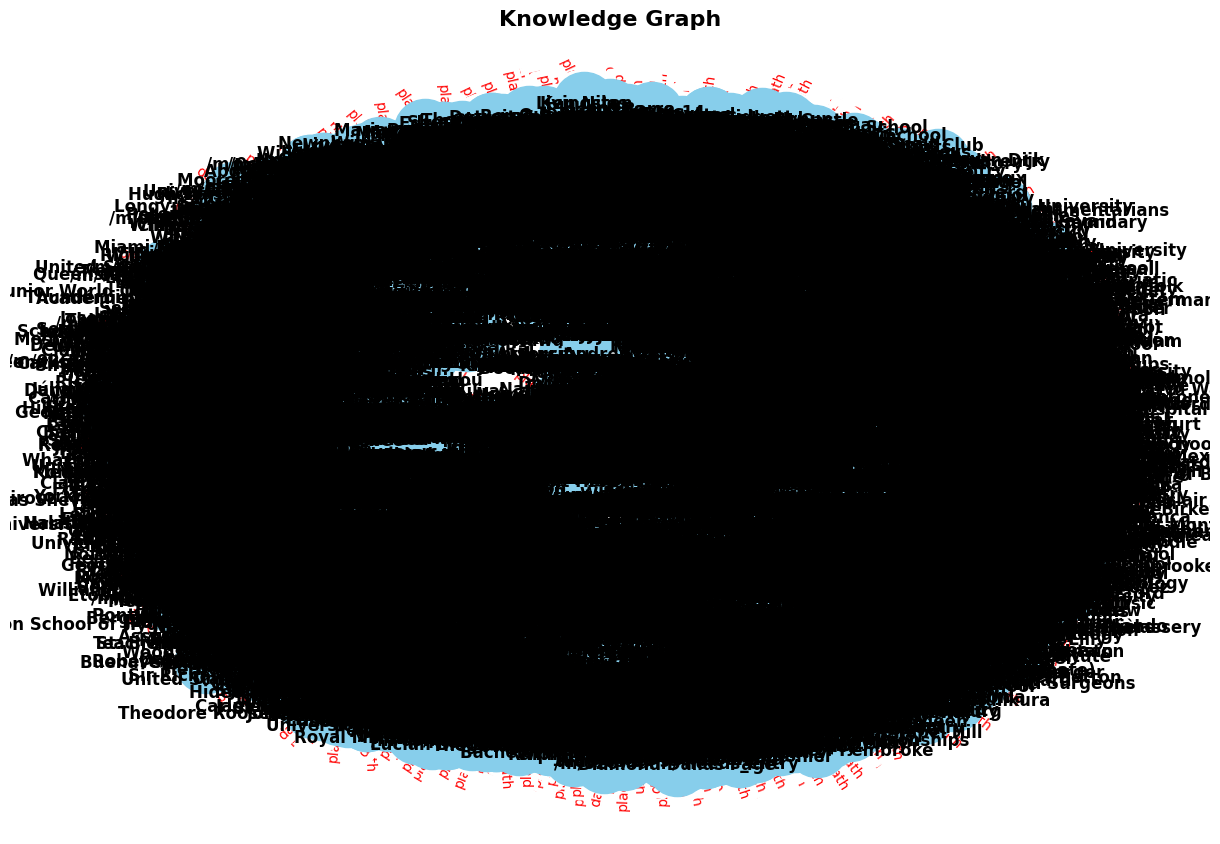

In [ ]:
plt.figure(figsize=(12, 8))

# Layout algorithm for visualization
pos = nx.spring_layout(graph, seed=42)

# Draw nodes and edges
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='skyblue', edge_color='gray', font_size=12, font_weight='bold')

# Draw edge labels with adjusted positioning and style
edge_labels = nx.get_edge_attributes(graph, 'relation')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='red', font_size=10, label_pos=0.5)

plt.title("Knowledge Graph", fontsize=16, fontweight='bold')
plt.axis('off')  # Hide the axis

# Display the graph
plt.tight_layout()
plt.show()


## ........  **6 - 3: Dynamic Graph** ............

In [ ]:
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Ploting Dynamic Graph
def visualize_dynamic_graph(graph, title='Knowledge Graph', seed=42):
    # Layout algorithm for visualization
    pos = nx.spring_layout(graph, seed=seed)

    # Extract edges and node positions
    edge_x = []
    edge_y = []
    edge_text = []  # To store the relation information
    for edge in graph.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_text.append(edge[2]['relation'])  # Add the relation to edge_text

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='gray'),
        hoverinfo='text',  # Set hoverinfo to 'text'
        text=edge_text,  # Use edge_text for hover text
        mode='lines')

    node_x = []
    node_y = []
    node_text = []  # To store the node labels
    for node in graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,  # Use node_text for hover text
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color='skyblue',
            size=20,
            line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text=title,
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )

    fig.show()

In [ ]:
visualize_dynamic_graph(graph = graph, title='Knowledge Graph', seed=42)


KeyboardInterrupt



### **KG for Specific Predicate of interest, such as institution **

In [ ]:
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Define the predicate of interest (relation between sub and obj)
predicate_of_interest = 'institution'

# Initialize the graph
graph = nx.Graph()

# Add nodes and edges from results where the predicate matches the one of interest(relation)
for index, row in df_KG_limited.iterrows():
    sub = row['sub']
    obj = row['obj']
    pred = row['pred']

    if pred == predicate_of_interest:
        # Add nodes if not already in the graph
        if sub not in graph.nodes:
            graph.add_node(sub)
        if obj not in graph.nodes:
            graph.add_node(obj)

        # Add edge with predicate as relationship
        graph.add_edge(sub, obj, relation=pred)

In [ ]:
visualize_dynamic_graph(graph = graph, title='Knowledge Graph', seed=42)